In [1]:
# !pip install numpy==1.23.5
import matplotlib.pyplot as plt
import os
import sys

args = 6
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Selected GPU 6
Jax version:         0.4.16
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: gpu
Jax devices:         [gpu(id=0)]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('/home/davcic/base_GP_CP')
# from New_kernel_1 import Discontinuous_multiple
# from New_kernel_1 import Discontinuous_multiple_params
# from New_kernel_1 import Discontinuous_multiple_params_hyper
from GP_CP_models.Poisson.Poisson_Process import Poisson_Process_hyper
from GP_CP_models.fullgp import FullMarginalGPModelhyper_mult
from GP_CP_models.Normal_modified import LogNormal_mod
from GP_CP_models.fullgp import FullLatentGPModelhyper_mult
import GP_CP_models.CP_kernels as kernels
from GP_CP_models.GP_CP_class import GP_CP_Marginal, GP_CP_Latent


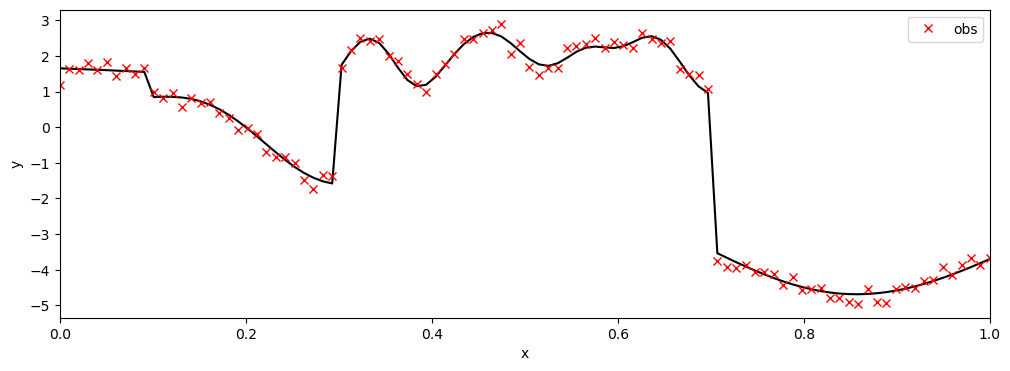

In [37]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = kernels.RBF_CP(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_
                    )

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [38]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = kernels.RBF_CP(base_kernel)

priors = dict(kernel=dict(
                          lengthscale=LogNormal_mod(0, 3, max_CP+1),
                          variance=LogNormal_mod(0.5, 1, max_CP+1), 
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_pp = LogNormal_mod(0, 1, 1)))


### GP Class

### Marginal GP

In [42]:
num_particles = 1_000
num_mcmc_steps = 100
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, 
                             num_particles=num_particles, num_mcmc_steps=num_mcmc_steps,
                             poisson = True)

In [43]:
GP_marginal.model_GP(key)

Running Marginal GP


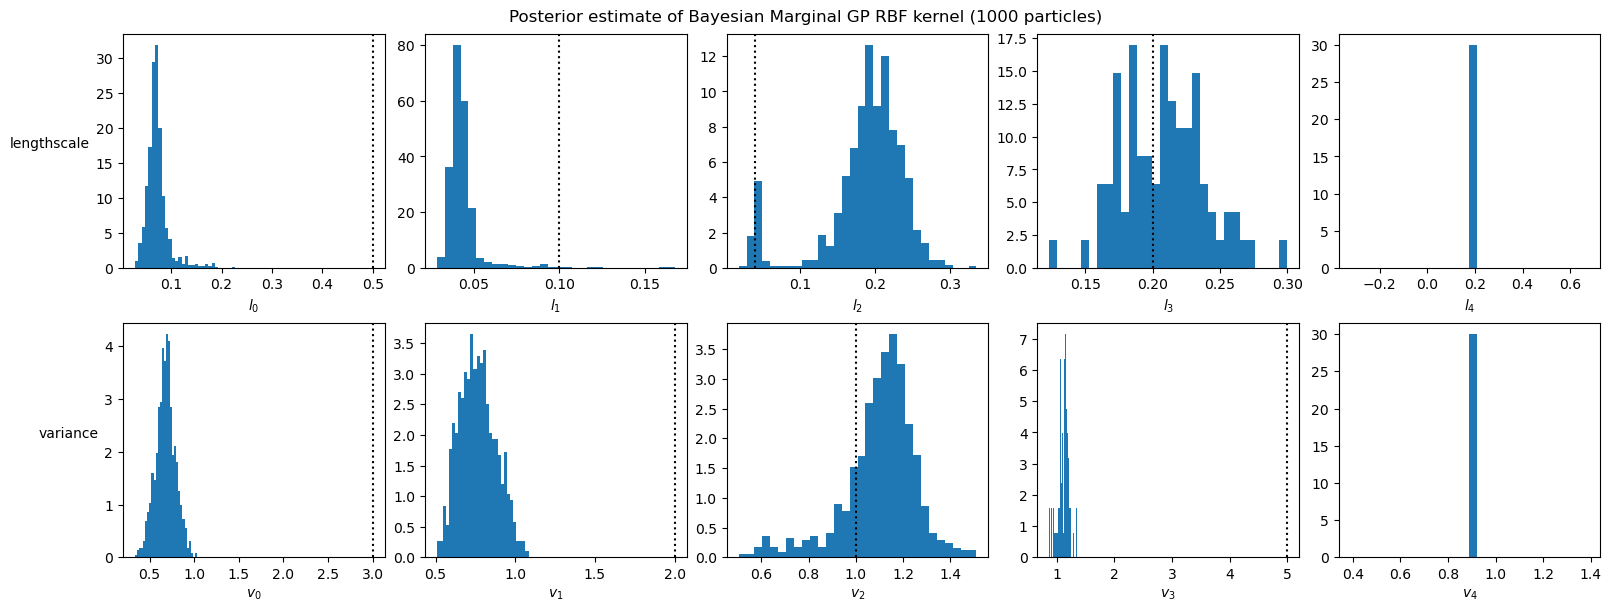

In [44]:
GP_marginal.plot_post(ground_truth)

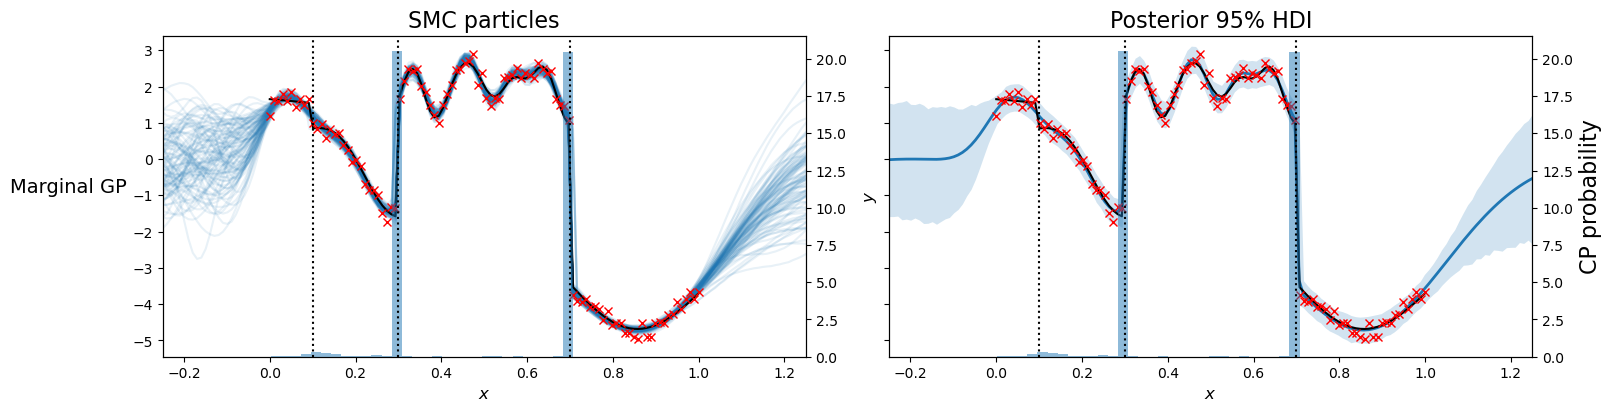

In [45]:
GP_marginal.plot_fit(key, True, f_true, ground_truth)

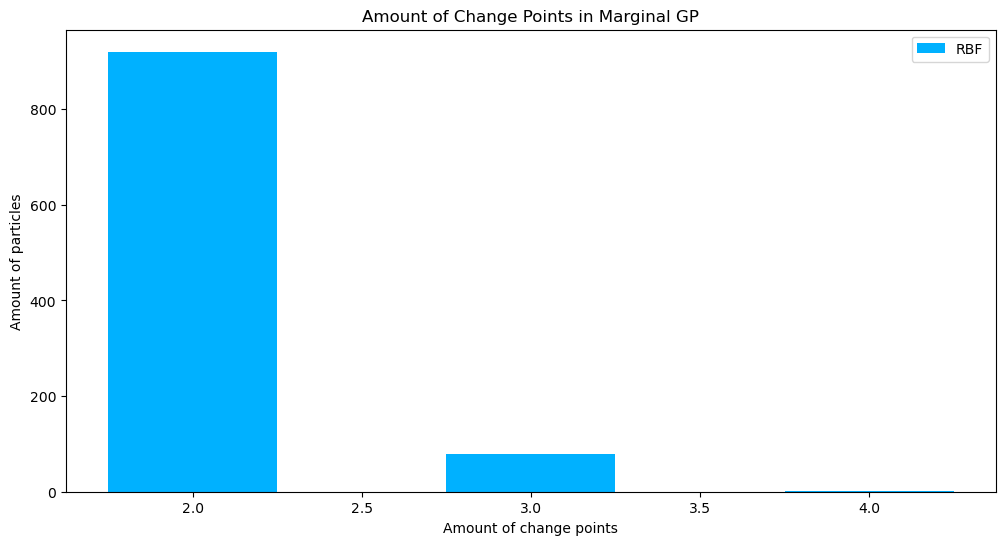

In [46]:
GP_marginal.plot_num()

In [47]:
print(f"Marginal GP number metric: {GP_marginal.number_metric(ground_truth)}")
# print(f'Marginal GP locations metric: {GP_marginal.location_metric(ground_truth)}')
print(f'Marginal GP likelihood metric: {GP_marginal.likelihood_metric(key)}')
print(f'Marginal GP Jaccard maetric: {GP_marginal.jaccard_metric(ground_truth)}')

Marginal GP number metric: -0.13128571428571428
Marginal GP likelihood metric: 45.7893372313371
Marginal GP Jaccard maetric: 0.9605262


### Latent GP

In [17]:
num_particles = 1_000
num_mcmc_steps = 1000
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [18]:
GP_latent.model_GP(key)

Running Latent GP


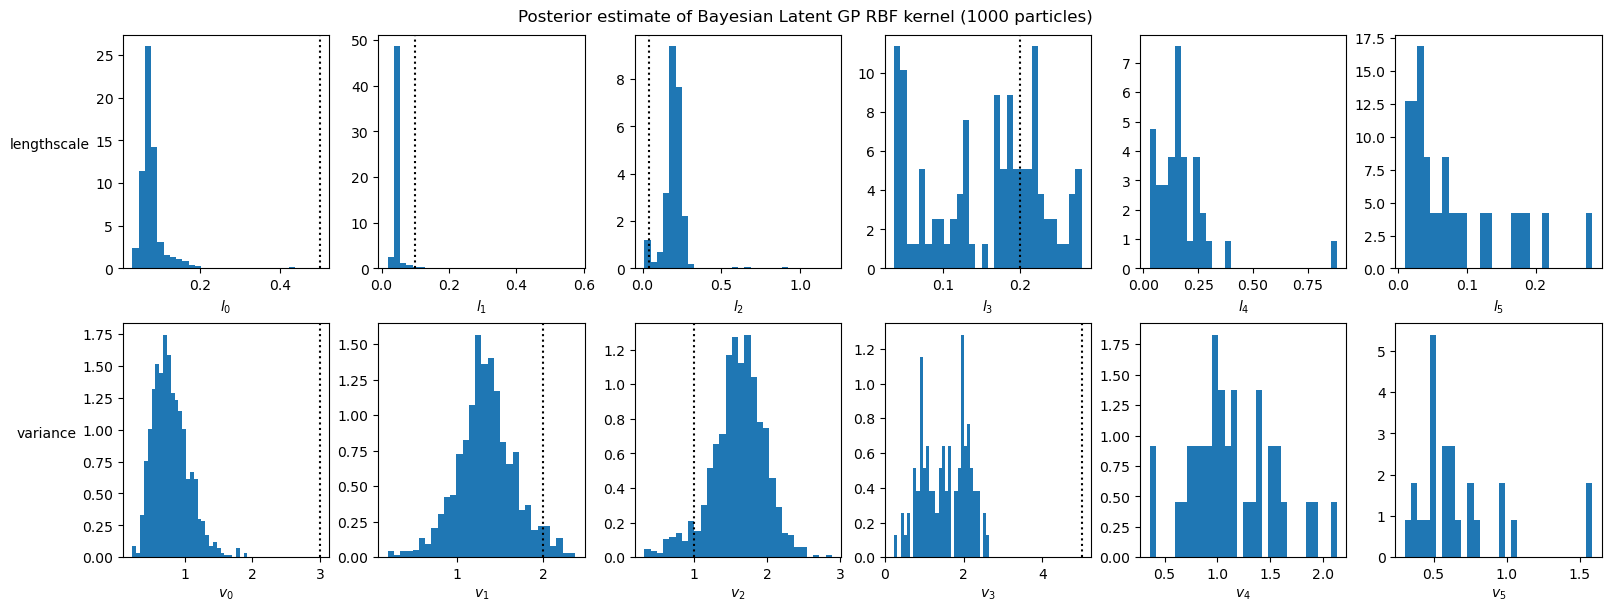

In [19]:
GP_latent.plot_post(ground_truth)

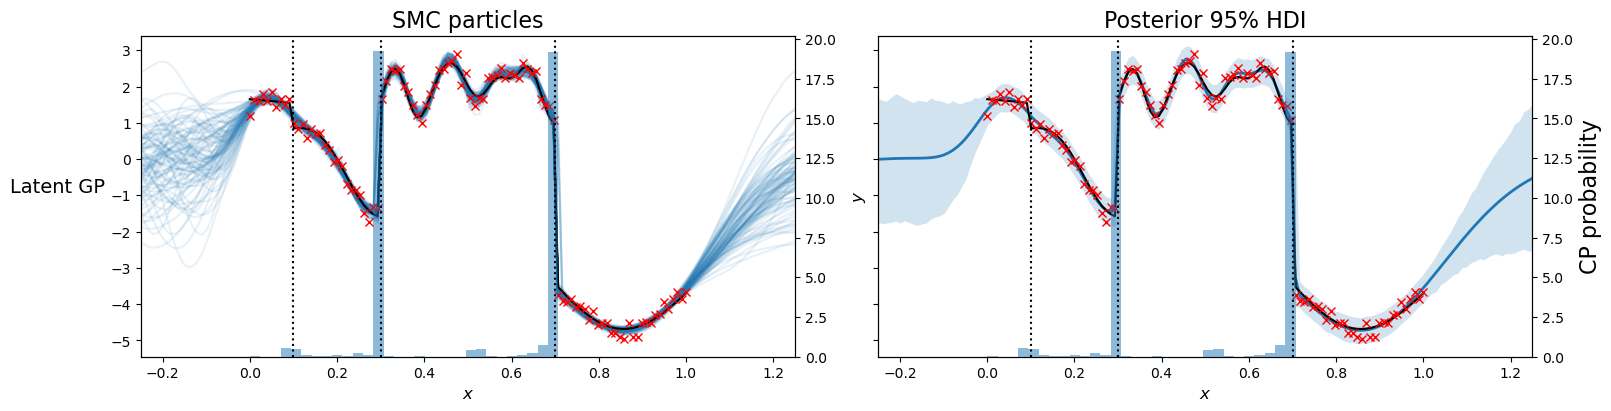

In [20]:
GP_latent.plot_fit(key, True, f_true, ground_truth)

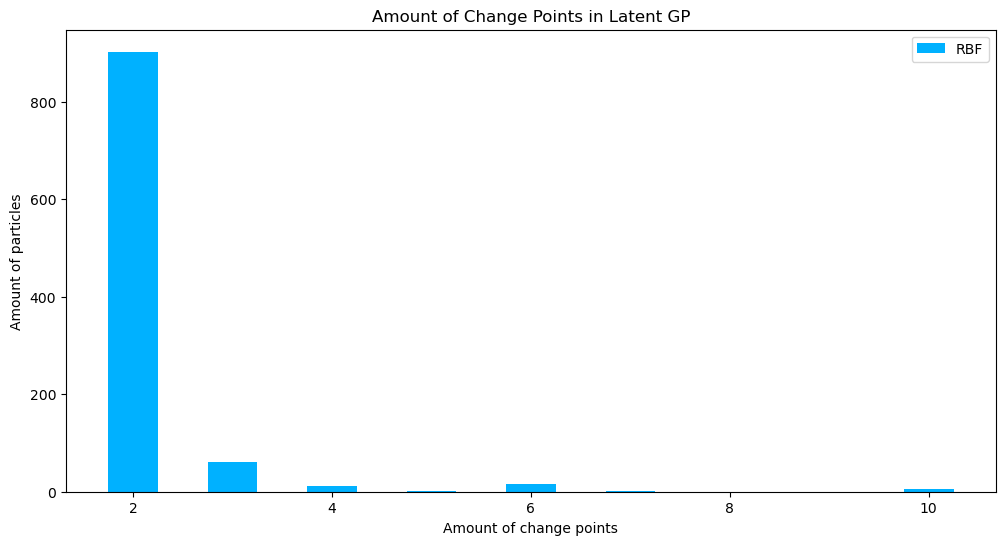

In [21]:
GP_latent.plot_num()

In [22]:
print(f"Latent GP number metric: {GP_latent.number_metric(ground_truth)}")
# print(f'Latent GP locations metric: {GP_latent.location_metric(ground_truth)}')
print(f'Latent GP likelihood metric: {GP_latent.likelihood_metric(key)}')
print(f'Latent GP Jaccard maetric: {GP_latent.jaccard_metric(ground_truth)}')

Latent GP number metric: -0.11285714285714286
Latent GP likelihood metric: 45.94396515735039
Latent GP Jaccard maetric: 0.9571856


In [23]:
print(GP_latent.likelihood)

-70.27769355334344


### Testing combined kernels

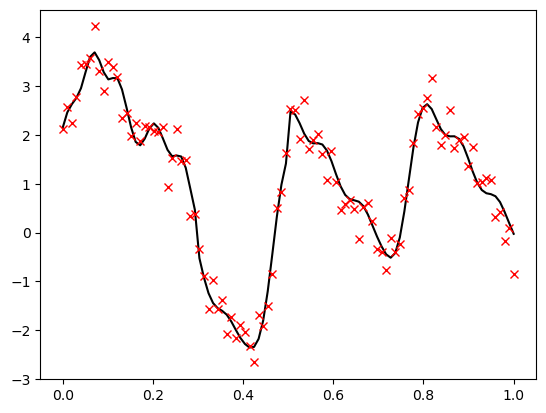

In [4]:
key = jrnd.PRNGKey(123456)

base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

kernel = kernels.RBF_CP(base_kernel1) + kernels.Periodic_CP(base_kernel2)

key, key1 = jrnd.split(key)
lengthscale1 = jnp.array([0.1, 1])
variance1 = jnp.array([2, 1])
lengthscale2 = jnp.array([0.4, 0.5])
variance2 = jnp.array([0.5, 2])
period = jnp.array([0.2, 0.3])
num1 = jnp.array([0.5])
num2 = jnp.array([0.3])

params = [dict(lengthscale= lengthscale1,
                            variance = variance1,
                            num = num1), 
              dict(lengthscale= lengthscale2,
                            variance = variance2,
                            period = period, 
                            num = num2)]
x = jnp.linspace(0, 1, 100)


K = kernel.cross_covariance(params, x, x)

n = 100
obs_noise_ = 0.3
L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))


ground_truth = dict(f=f_true,
                    kernel = [dict(lengthscale=lengthscale1,
                                    variance=variance1,
                                    num = num1),
                                dict(lengthscale=lengthscale2,
                                    variance=variance2,
                                    period = period,
                                    num = num2)],
                    obs_noise=obs_noise_
                    ) 

plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.show()

In [5]:
num_particles = 1_000
num_mcmc_steps = 100
T = 1
max_CP = 10

base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()
kernel = kernels.RBF_CP(base_kernel1) + kernels.Periodic_CP(base_kernel2)

priors = dict(kernel=[  dict(
                          lengthscale=LogNormal_mod(0, 1, max_CP+1),
                          variance=LogNormal_mod(0, 1, max_CP+1), 
                          num=Poisson_Process_hyper(max_CP, T)),
                        dict(
                          lengthscale=LogNormal_mod(0, 1, max_CP+1),
                          variance=LogNormal_mod(0, 1, max_CP+1), 
                          period=LogNormal_mod(0, 1, max_CP+1), 
                          num=Poisson_Process_hyper(max_CP, T))],
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = [dict(hyper_pp1 = LogNormal_mod(0, 1, 1)),
                       dict(hyper_pp2 = LogNormal_mod(0, 1, 1))])

GP_marginal_mult = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors,
                                   num_particles=num_particles, num_mcmc_steps=num_mcmc_steps,
                                   poisson=True)

In [6]:
GP_marginal_mult.model_GP(key)

Running Marginal GP


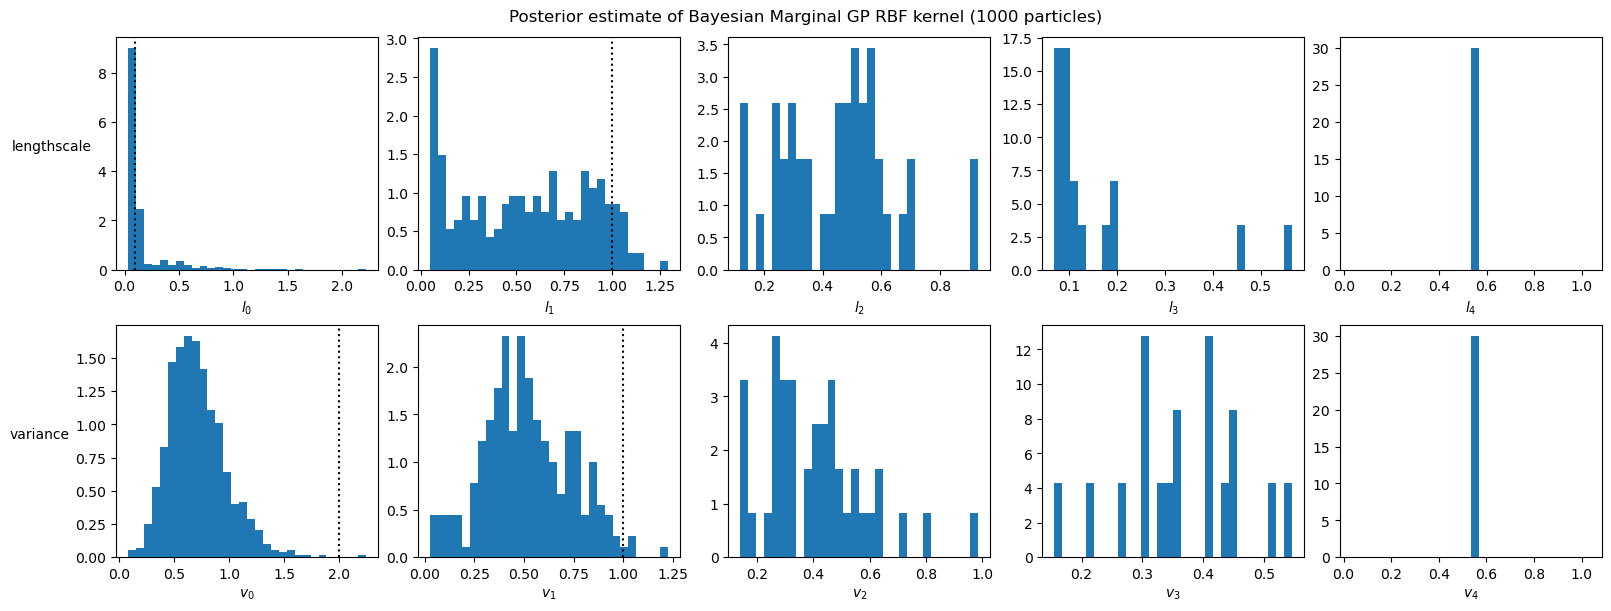

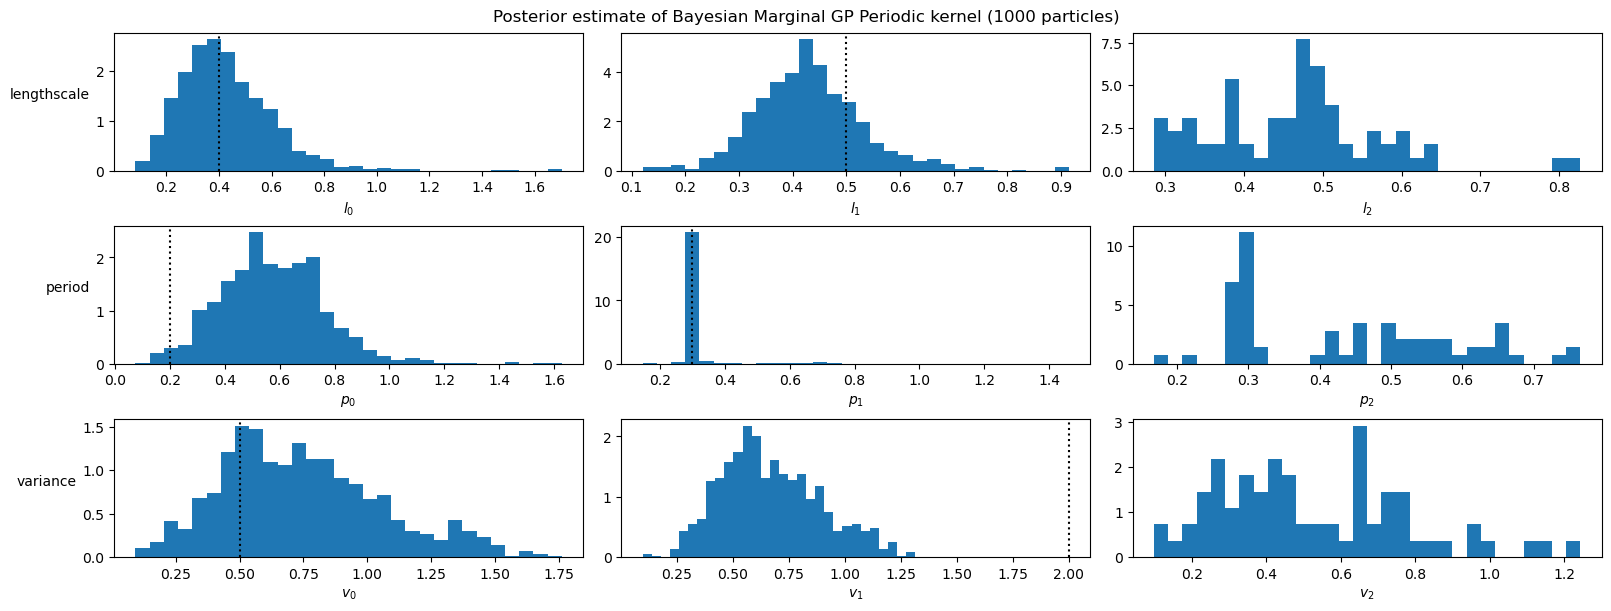

In [7]:
GP_marginal_mult.plot_post(ground_truth)

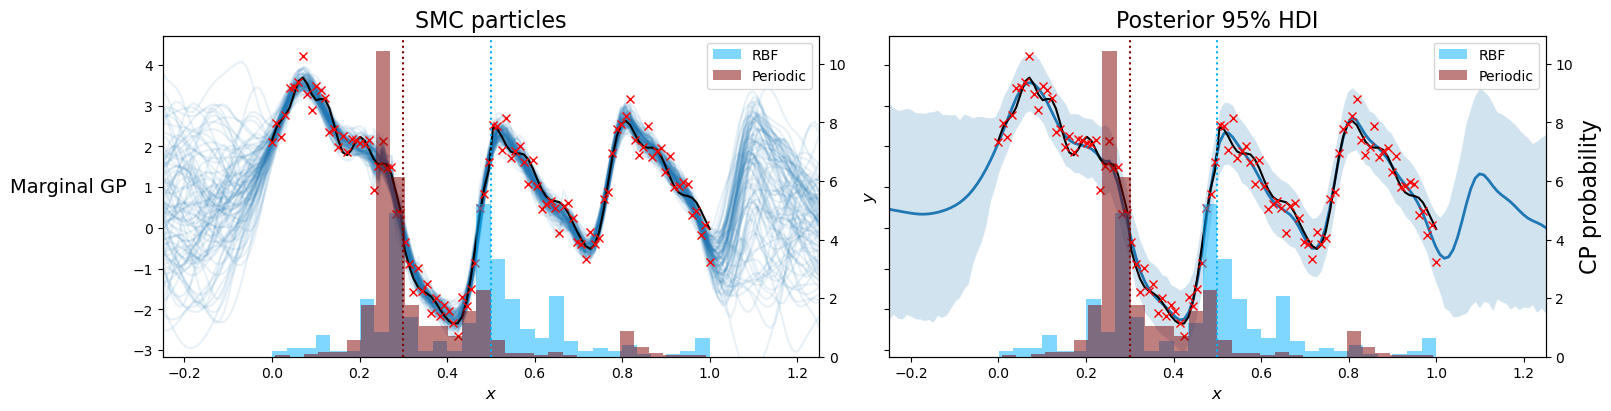

In [8]:
GP_marginal_mult.plot_fit(key, True, f_true, ground_truth)

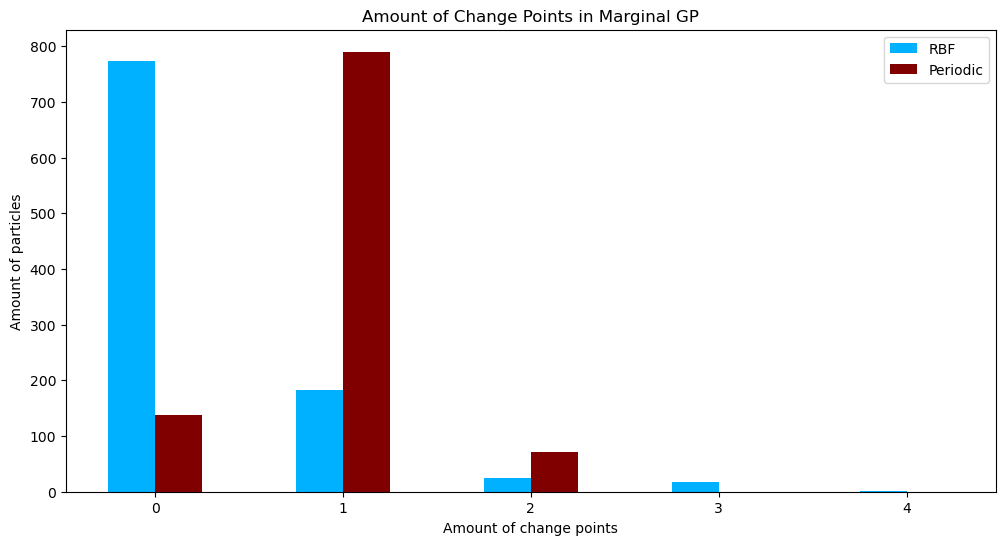

In [9]:
GP_marginal_mult.plot_num()

In [10]:
print(f"Marginal GP number metric: {GP_marginal_mult.number_metric(ground_truth)}")
# print(f'Marginal GP locations metric: {GP_marginal_mult.location_metric(ground_truth)}')
print(f'Marginal GP likelihood metric: {GP_marginal_mult.likelihood_metric(key)}')
print(f'Marginal GP Jaccard maetric: {GP_marginal_mult.jaccard_metric(ground_truth)}')

Marginal GP number metric: {'RBF': -0.0791111111111111, 'Periodic': -0.007333333333333327}
Marginal GP likelihood metric: -18.19162546450066
Marginal GP Jaccard maetric: 0.7246736
